# **LAB 01: TRỰC QUAN HÓA DỮ LIỆU VỚI PYTHON**
#### Môn học: Trực quan hóa dữ liệu
#### Nhóm: 5


## **A. Thu thập dữ liệu**

Đối với một doanh nghiệp, một trong những yếu tố cốt lõi để cấu thành nên sự thành công đó chính là khách hàng. Doanh nghiệp không bán sản phẩm họ cung cấp, mà họ bán sản phẩm mà người khác cần. Thật khó để một doanh nghiệp có thể duy trì nếu họ không có hoặc mất đi những khách hàng của chính họ. Vậy làm thế nào để một doanh nghiệp có thể thu hút ngày càng nhiều khách hàng cũng như đồng thời giữ được những người trung thành, đặc biệt là trong một thị trường đòi hỏi nhiều hơn là chỉ bán dịch vụ và sản phẩm đơn thuần. Chính vì thế, việc tìm hiểu và phân tích nhu cầu khách hàng chính là một trong những việc làm quan trọng, một bài toàn toán khó cho các doanh nghiệp hiện nay.

Thấy được tầm quan trọng của việc phân tích khách hàng, nhóm 5 lựa chọn bộ dữ liệu *Shop Customer Data* cho lab 01. Bộ dữ liệu được chia sẻ miễn phí trên nền tảng Kaggle. (Link dataset: https://www.kaggle.com/datasets/datascientistanna/customers-dataset)

License: <a href="http://opendatacommons.org/licenses/dbcl/1.0/">Database: Open Database, Contents: Database Contents</a>


Bộ dữ liệu được thu thập thủ công. Phương pháp thu thâp là thu thập thông qua nghiên cứu kéo dài 1 năm về khách hàng của các cửa hàng địa phương.


## **B. Khám phá dữ liệu**

### **Import các thư viện**

In [199]:
import pandas as pd

import seaborn as sns
import plotly.express as px
import plotly.offline as py
import matplotlib.pyplot as plt
import numpy as np


from sklearn.preprocessing import OneHotEncoder

import category_encoders as ce

%matplotlib inline  
py.init_notebook_mode(connected=True)

### **Đọc file dữ liệu vào dataframe**

In [200]:
df=pd.read_csv("Customers.csv")
df.head()


,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


### **Tiền xử lý và khám phá dữ liệu**

**Số dòng** và **số cột** của bộ dữ liệu: 2000 dòng, 8 cột

In [201]:
num_rows, num_cols = df.shape
print("Num rows: ", num_rows)
print("Num cols: ", num_cols)

Num rows:  2000
Num cols:  8


**Ý nghĩa của mỗi dòng**: Thông tin của một khách hàng mua sắm ở cửa hàng. Không có dòng nào mang ý nghĩa khác. 

In [202]:
df.head(1)

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4


Kiểm tra xem có dòng nào bị trùng lặp hay không:

In [203]:
df.duplicated().sum()

0

**Ý nghĩa của mỗi cột**: 

- `Customer ID`: ID khách hàng
- `Gender`: Giới tính
- `Age`: Tuổi
- `Annual Income`: Thu nhập hàng năm (đơn vị: $)
- `Spending Score`: Điểm do cửa hàng chấm, dựa trên hành vi và tính chất chi tiêu của khách hàng. Nằm trong khoảng [0,100]
- `Profession`: Nghề nghiệp
- `Work Experience`: Kinh nghiệm làm việc (đơn vị: năm)
- `Family Size`: Số thành viên trong gia đình

Ta sẽ thực hiện chuẩn hóa tên các cột để thuận tiện hơn cho việc sử dụng về sau:

In [204]:
df = df.rename(columns={'Annual Income ($)': 'Annual_Income',
                        'Spending Score (1-100)': 'Spending_Score',
                        'Work Experience':'Work_Experience',
                        'Family Size':'Family_Size'})
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual_Income', 'Spending_Score',
       'Profession', 'Work_Experience', 'Family_Size'],
      dtype='object')

**Kiểu dữ liệu của mỗi cột:**

In [205]:
df.dtypes

CustomerID          int64
Gender             object
Age                 int64
Annual_Income       int64
Spending_Score      int64
Profession         object
Work_Experience     int64
Family_Size         int64
dtype: object

Các cột đều có kiểu dữ liệu phù hợp, không cần xử lý.

**Kiểm tra giá trị bị thiếu:**

In [206]:
df.isna().sum()

CustomerID          0
Gender              0
Age                 0
Annual_Income       0
Spending_Score      0
Profession         35
Work_Experience     0
Family_Size         0
dtype: int64

Có 35 giá trị thiếu ở cột `Profession`.

**Phân bố giá trị của các cột numeric:**

Dựa vào việc kiểm tra kiểu dữ liệu của các cột ở bước trên, ta đang có 6 cột có vẻ thuộc nhóm **numeric** là: `CustomerID`, `Age`, `Annual_Income`, `Spending_Score`, `Work_Experience`, `Family_Size`. Tuy nhiên, cột `CustomerID` thật ra lại là dạng **categorical** (vì ID là mã được đánh dưới dạng 

Bảng thống kê cơ bản về các phân bố giá trị của các thuộc tính **numeric**:

In [207]:
df[['Age', 'Annual_Income', 'Spending_Score', 'Work_Experience', 'Family_Size']].describe()

,Age,Annual_Income,Spending_Score,Work_Experience,Family_Size
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,48.960000,110731.821500,50.962500,4.102500,3.768500
std,28.429747,45739.536688,27.934661,3.922204,1.970749
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25.000000,74572.000000,28.000000,1.000000,2.000000
50%,48.000000,110045.000000,50.000000,3.000000,4.000000
75%,73.000000,149092.750000,75.000000,7.000000,5.000000
max,99.000000,189974.000000,100.000000,17.000000,9.000000


Nhìn tổng quan, khách hàng có tuổi nhỏ nhất là 0. Ta thử truy vấn:

In [208]:
df[df["Age"]==0]

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
211,212,Female,0,22000,92,Artist,2,1
228,229,Male,0,33000,64,Marketing,1,1
333,334,Male,0,173743,96,Artist,0,4
440,441,Female,0,57373,29,NaN,0,7
443,444,Female,0,68761,16,Lawyer,1,4
466,467,Male,0,186002,80,Doctor,15,2
559,560,Male,0,151298,89,Artist,0,6
562,563,Female,0,142892,25,Entertainment,8,1
767,768,Female,0,143910,22,Marketing,1,7
794,795,Female,0,147719,86,Lawyer,1,7


Có vẻ như người thu thập đã điền giá trị 0 cho các khách hàng không có thông tin về độ tuổi. Ta sẽ thực hiện 

**Phân bố giá trị của các cột categorical:**

Có 3 cột thuộc nhóm **categorical** là: `CustomerID`, `Gender`, `Profession`

Kiểm tra số giá trị trùng lặp ở cột `CustomerID`:

In [209]:
df["CustomerID"].duplicated().sum()

0

Mỗi ID khách hàng là duy nhất, không có sự trùng lặp

Bỏ qua thuộc tính `CustomerID`, ta có bảng thống kê cơ bản về các phân bố giá trị của các thuộc tính **categorical** còn lại:

In [210]:
df[['Gender','Profession']].describe()

,Gender,Profession
count,2000,1965
unique,2,9
top,Female,Artist
freq,1186,612


**Làm sạch dữ liệu:**

Ta lần lượt đi kiểm tra giá trị trong từng cột dữ liệu và tiền xử lý (nếu cần)

**Cột `CustomerID`**: Dựa vào kết quả kiểm tra các bước ở trên, các giá trị ở cột `CustomerID` đều khác nhau nên không có vấn đề gì cần tiền xử lý.

**Cột `Gender`**:

<AxesSubplot:xlabel='Gender', ylabel='count'>

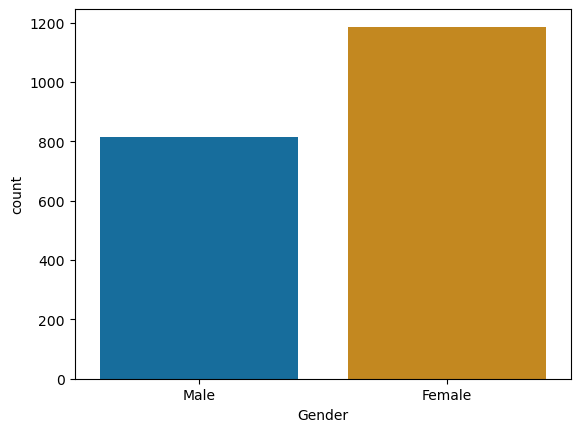

In [211]:
sns.countplot(x='Gender', data=df,palette="colorblind")

**Cột `Age`**:

In [212]:
fig = px.box(df, x="Age",width=800, height=400)
fig.show()

Phân bố của độ tuổi khá đẹp. Ta sẽ thực hiện thay thế những khách hàng có độ tuổi 0 giá trị trung vị các khách hàng có độ tuổi khác 0 để bộ dữ liệu hợp lý hơn: 

In [213]:
df.loc[df["Age"]==0,"Age"]=int(df[df["Age"]>0]["Age"].median())

**Cột `Annual_Income`**:

In [214]:
fig = px.box(df,x='Annual_Income',width=800, height=400)
fig.show()

In [215]:
fig = px.box(df, y="Annual_Income",x='Age')
fig.show()

Nhìn chung thì có một vài outliers, có thể đây là những trường hợp cá biệt nên ta sẽ không xử lý.

**Cột `Spending_Score`**: là cột do chủ cửa hàng điền, ta sẽ bàn luận sâu hơn khi thực hiện phân tích rõ mối quan hệ các thuộc tính.

**Cột `Profession`**:

<AxesSubplot:xlabel='Profession', ylabel='count'>

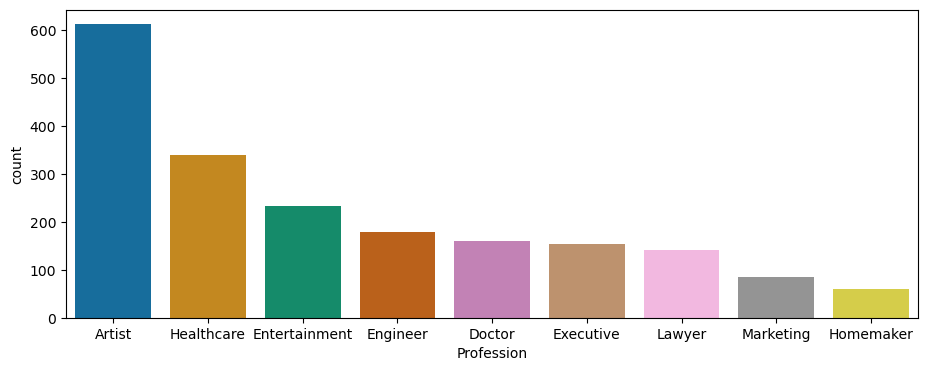

In [216]:
plt.figure(figsize=(11,4))
sns.countplot(x='Profession', data=df,palette="colorblind",order = df['Profession'].value_counts().index)

Điền các giá trị bị thiếu trong cột `Profession` bằng giá trị mode:

In [217]:
df['Profession'] = df['Profession'].fillna(df['Profession'].mode()[0])
df['Profession'].isna().sum()

0

**Cột `Work_Experience`**:

In [218]:
fig = px.box(df, x="Work_Experience",width=800, height=400)
fig.show()

Nhìn vào đồ thị, ta thấy `Work_Experience` có một giá trị outlier là 17. Thực hiện truy vấn những dòng này:

In [219]:
df[df['Work_Experience'] == 17]

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
392,393,Male,21,119116,30,Artist,17,4
405,406,Female,65,119889,11,Artist,17,6
473,474,Male,20,130813,92,Artist,17,5
566,567,Female,19,180331,14,Artist,17,5
603,604,Female,91,69720,78,Lawyer,17,6


Với `Profession` là _"Artist"_ thì nhìn chung những outlier vẫn khá hợp lý nên ta sẽ giữ lại 5 dòng này.

In [220]:
fig = px.box(df, y="Work_Experience",x='Age')
fig.show()

Có khá nhiều outliers khi ta trực quan hóa kết hợp với cột `Age`, nhìn vào các outliers ta nhận ra một vài vấn đề sai về dữ liệu như như 8 tuổi có 14 năm kinh nghiệm, 19 tuổi có 17 năm kinh nghiệm,...

In [221]:
df[df['Work_Experience'] - df['Age'] >= 0]

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
210,211,Female,1,57000,93,Engineer,1,2
230,231,Female,6,93000,53,Lawyer,8,2
234,235,Female,4,84000,54,Artist,9,1
321,322,Male,5,69078,60,Lawyer,13,1
338,339,Female,7,123804,28,Doctor,14,1
...,...,...,...,...,...,...,...,...
1923,1924,Male,2,101718,11,Executive,8,3
1926,1927,Male,3,74607,69,Healthcare,6,1
1951,1952,Male,1,57522,75,Artist,10,5
1984,1985,Female,2,153622,51,Lawyer,6,6


Ta sẽ loại bỏ những dòng có `Work_Experience` lớn hơn `Age`:

In [222]:
df = df.drop(df[df['Work_Experience'] - df['Age'] >= 0].index)

**Cột `Family_Size`:**

In [223]:
fig = px.box(df, x="Family_Size",width=800, height=400)
fig.show()

Dataframe sau khi thực hiện tiền xử lý:

In [224]:
df

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...,...
1995,1996,Female,71,184387,40,Artist,8,7
1996,1997,Female,91,73158,32,Doctor,7,7
1997,1998,Male,87,90961,14,Healthcare,9,2
1998,1999,Male,77,182109,4,Executive,7,2


#### **C. Khám phá mối quan hệ trong dữ liệu**

Dùng chung `df` để đỡ phải sửa khi merge nha

#### **D. Xây dựng mô hình học máy**

**Chuẩn bị dữ liệu**: 

One-hot encoding

In [225]:
encoder=ce.OneHotEncoder(cols=['Gender','Profession'], return_df=True,use_cat_names=True)

df_encoded = encoder.fit_transform(df)

In [226]:
df

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...,...
1995,1996,Female,71,184387,40,Artist,8,7
1996,1997,Female,91,73158,32,Doctor,7,7
1997,1998,Male,87,90961,14,Healthcare,9,2
1998,1999,Male,77,182109,4,Executive,7,2


In [227]:
df_encoded=df_encoded.drop(columns="CustomerID")

In [228]:
df_encoded.dtypes

Gender_Male                 int64
Gender_Female               int64
Age                         int64
Annual_Income               int64
Spending_Score              int64
Profession_Healthcare       int64
Profession_Engineer         int64
Profession_Lawyer           int64
Profession_Entertainment    int64
Profession_Artist           int64
Profession_Executive        int64
Profession_Doctor           int64
Profession_Homemaker        int64
Profession_Marketing        int64
Work_Experience             int64
Family_Size                 int64
dtype: object

In [229]:
df_encoded.skew()

Gender_Male                 0.379870
Gender_Female              -0.379870
Age                         0.051234
Annual_Income              -0.110919
Spending_Score              0.014014
Profession_Healthcare       1.755462
Profession_Engineer         2.854272
Profession_Lawyer           3.363856
Profession_Entertainment    2.382214
Profession_Artist           0.758020
Profession_Executive        3.187477
Profession_Doctor           3.106555
Profession_Homemaker        5.546428
Profession_Marketing        4.526727
Work_Experience             0.737301
Family_Size                 0.199234
dtype: float64

In [230]:
df_encoded["Work_Experience"] = np.sqrt(df_encoded["Work_Experience"])

In [231]:
df_encoded

,Gender_Male,Gender_Female,Age,Annual_Income,Spending_Score,Profession_Healthcare,Profession_Engineer,Profession_Lawyer,Profession_Entertainment,Profession_Artist,Profession_Executive,Profession_Doctor,Profession_Homemaker,Profession_Marketing,Work_Experience,Family_Size
0,1,0,19,15000,39,1,0,0,0,0,0,0,0,0,1.000000,4
1,1,0,21,35000,81,0,1,0,0,0,0,0,0,0,1.732051,3
2,0,1,20,86000,6,0,1,0,0,0,0,0,0,0,1.000000,1
3,0,1,23,59000,77,0,0,1,0,0,0,0,0,0,0.000000,2
4,0,1,31,38000,40,0,0,0,1,0,0,0,0,0,1.414214,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,1,71,184387,40,0,0,0,0,1,0,0,0,0,2.828427,7
1996,0,1,91,73158,32,0,0,0,0,0,0,1,0,0,2.645751,7
1997,1,0,87,90961,14,1,0,0,0,0,0,0,0,0,3.000000,2
1998,1,0,77,182109,4,0,0,0,0,0,1,0,0,0,2.645751,2


In [232]:
from scipy.stats import zscore
df_encoded = df_encoded.apply(zscore)
df_encoded

,Gender_Male,Gender_Female,Age,Annual_Income,Spending_Score,Profession_Healthcare,Profession_Engineer,Profession_Lawyer,Profession_Entertainment,Profession_Artist,Profession_Executive,Profession_Doctor,Profession_Homemaker,Profession_Marketing,Work_Experience,Family_Size
0,1.207637,-1.207637,-1.206032,-2.076343,-0.423086,2.207161,-0.315684,-0.275010,-0.364340,-0.690596,-0.287942,-0.294257,-0.174917,-0.21122,-0.531639,0.116455
1,1.207637,-1.207637,-1.131641,-1.640514,1.077911,-0.453071,3.167725,-0.275010,-0.364340,-0.690596,-0.287942,-0.294257,-0.174917,-0.21122,0.101617,-0.391711
2,-0.828064,0.828064,-1.168837,-0.529151,-1.602440,-0.453071,3.167725,-0.275010,-0.364340,-0.690596,-0.287942,-0.294257,-0.174917,-0.21122,-0.531639,-1.408042
3,-0.828064,0.828064,-1.057250,-1.117520,0.934959,-0.453071,-0.315684,3.636237,-0.364340,-0.690596,-0.287942,-0.294257,-0.174917,-0.21122,-1.396684,-0.899877
4,-0.828064,0.828064,-0.759684,-1.575140,-0.387348,-0.453071,-0.315684,-0.275010,2.744692,-0.690596,-0.287942,-0.294257,-0.174917,-0.21122,-0.173326,1.132786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.828064,0.828064,0.728145,1.614843,-0.387348,-0.453071,-0.315684,-0.275010,-0.364340,1.448024,-0.287942,-0.294257,-0.174917,-0.21122,1.050031,1.640951
1996,-0.828064,0.828064,1.472059,-0.808996,-0.673252,-0.453071,-0.315684,-0.275010,-0.364340,-0.690596,-0.287942,3.398385,-0.174917,-0.21122,0.892009,1.640951
1997,1.207637,-1.207637,1.323277,-0.421044,-1.316536,2.207161,-0.315684,-0.275010,-0.364340,-0.690596,-0.287942,-0.294257,-0.174917,-0.21122,1.198449,-0.899877
1998,1.207637,-1.207637,0.951319,1.565202,-1.673916,-0.453071,-0.315684,-0.275010,-0.364340,-0.690596,3.472927,-0.294257,-0.174917,-0.21122,0.892009,-0.899877


In [233]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import math

In [234]:
# Function returns WSS score and Silhouette Score for k values from 2 to kmax
def calculate_WSS_Silhouette(x, kmax): #points
    wss=[]
    silhouetteScore=[]
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters=k)
        # fitting kmeans
        kmeans.fit(x)
        # wss
        wss.append(kmeans.inertia_)
        
        cluster_labels=kmeans.labels_  
        #silhouette score
        silhouetteScore.append(silhouette_score(x,cluster_labels))
    return wss, silhouetteScore

In [235]:
def plot_WSS_Silhouette(wss, silhouetteScore, kmax):
    plt.figure(figsize=(22,6))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, kmax+1), wss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WSS')
    plt.show()

    plt.figure(figsize=(22,6))
    plt.subplot(1, 2, 2)
    plt.plot(range(2, kmax+1), silhouetteScore)
    plt.title('The Silhouette Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

In [236]:
# Number of clusters used to calculate the WSS and Silhouette Score
kmax = 12

In [237]:
wss, silhouetteScore = calculate_WSS_Silhouette(df_encoded, kmax)

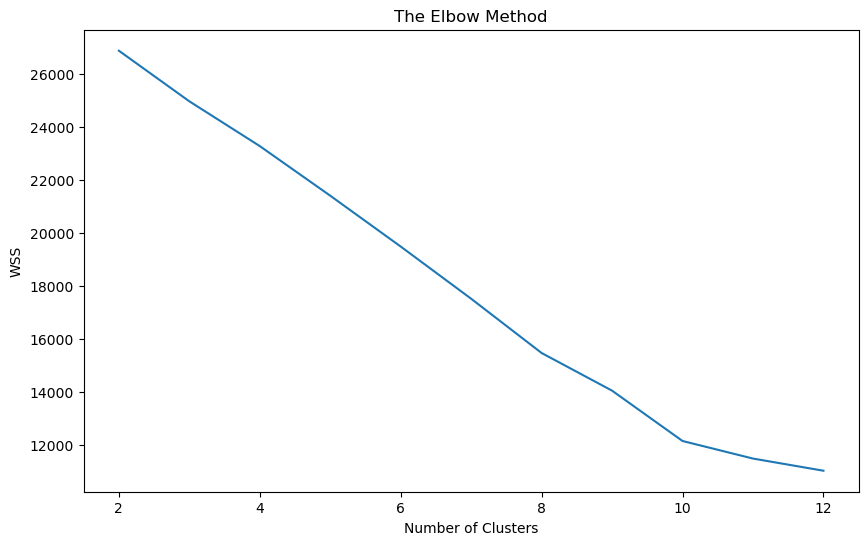

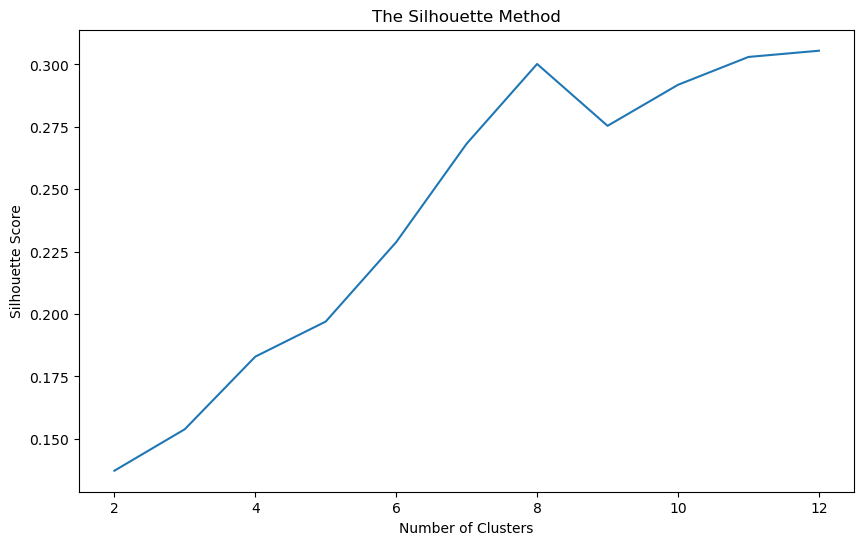

In [239]:
plot_WSS_Silhouette(wss, silhouetteScore, kmax)

In [240]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=3)
pca_result = pca.fit_transform(df_encoded)
print('Cumulative variance explained by 3 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by 3 principal components: 28.66%


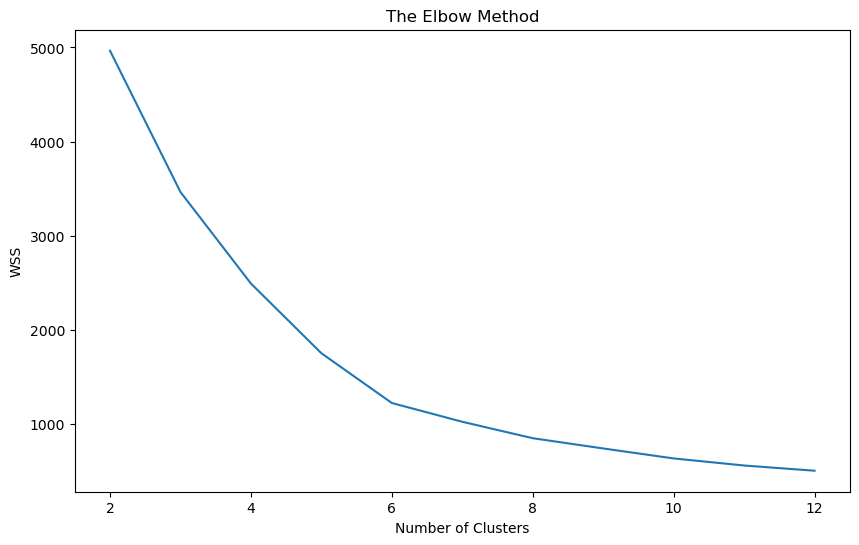

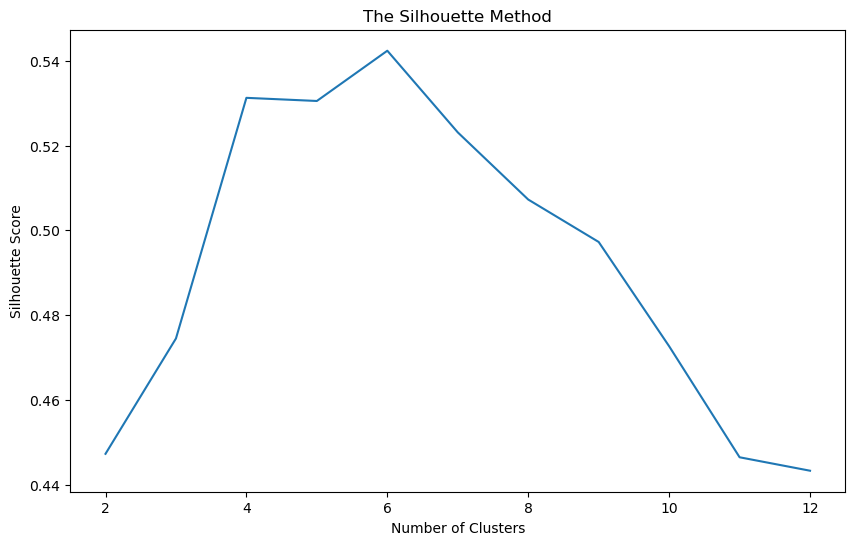

In [241]:
wss, silhouetteScore = calculate_WSS_Silhouette(pca_result, kmax)
plot_WSS_Silhouette(wss, silhouetteScore, kmax)

In [256]:
kmeans = KMeans(n_clusters = 4)
y_kmeans = kmeans.fit_predict(pca_result)
y_kmeans

array([1, 1, 2, ..., 1, 1, 1])

In [252]:
centroids=kmeans.cluster_centers_
centroids

array([[ 1.76092074, -0.52109573, -1.0103707 ],
       [-1.10480384, -0.78942512, -1.05657494],
       [-1.31035017,  1.53244318,  0.08667094],
       [ 1.78263864, -0.73699135,  0.95063016],
       [-1.0899269 , -0.97542585,  0.91503037],
       [ 1.55107899,  1.78460866,  0.12070994]])

In [253]:
df_results=pd.DataFrame(pca_result)
df_results["y_kmeans"]=y_kmeans
df_results["ID"]=df["CustomerID"]
df_results

,0,1,2,y_kmeans,ID
0,1.702524,-0.946577,-0.333814,0,1.0
1,1.729187,-0.200543,-0.959054,0,2.0
2,-1.073977,-0.734650,-0.885074,1,3.0
3,-1.300394,-0.488819,-2.593512,1,4.0
4,-1.094738,-0.867594,-1.632627,1,5.0
...,...,...,...,...,...
1915,-1.243095,1.272022,1.914968,2,1916.0
1916,-0.991688,-0.682792,0.665664,4,1917.0
1917,1.778162,-0.826245,1.368285,3,1918.0
1918,1.891497,-0.584684,1.370290,3,1919.0


In [254]:
df_results[df_results["ID"]== None]

,0,1,2,y_kmeans,ID


In [255]:
fig = px.scatter_3d(df_results, x=0, y=1, z=2,color='y_kmeans',hover_name = "ID")
fig.update_traces(marker_size = 2)
fig.show()